In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in fi lenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
# Load the data

data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [17]:
# Custom Dataset Class
class IMDbDataset(Dataset):
    def __init__(self, data, vocab, tokenizer):
        self.data = data
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        tokens = self.tokenizer(text)
        token_ids = [self.vocab[token] for token in tokens]
        label = 1 if label == "positive" else 0  # Convert labels to 0 and 1
        return torch.tensor(token_ids), torch.tensor(label)

# Tokenizer and Vocabulary
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(data), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# IMDb Dataset
train_dataset = IMDbDataset(data, vocab, tokenizer)
test_dataset = IMDbDataset(test_data, vocab, tokenizer)

# Collate function to pad sequences
def collate_fn(batch):
    texts, labels = zip(*batch)
    texts = pad_sequence(texts, batch_first=True, padding_value=vocab["<unk>"])
    labels = torch.stack(labels)
    return texts, labels

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [11]:
# Define the Bi-directional LSTM Model
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Take the last output
        output = self.fc(lstm_out)
        return output

In [18]:
# Model, Loss, Optimizer
vocab_size = len(vocab)
embedding_dim = 64
hidden_dim = 128
output_dim = 1

model = BiLSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    for texts, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_dataloader)}')

Epoch 1/100, Loss: 0.6826706230640411
Epoch 2/100, Loss: 0.6689639985561371
Epoch 3/100, Loss: 0.5988644659519196
Epoch 4/100, Loss: 0.4836452305316925
Epoch 5/100, Loss: 0.44796355068683624
Epoch 6/100, Loss: 0.5092923641204834
Epoch 7/100, Loss: 0.4846510887145996
Epoch 8/100, Loss: 0.37252362817525864
Epoch 9/100, Loss: 0.3522110730409622
Epoch 10/100, Loss: 0.4110128805041313
Epoch 11/100, Loss: 0.3720419257879257
Epoch 12/100, Loss: 0.2517261654138565
Epoch 13/100, Loss: 0.21245016902685165
Epoch 14/100, Loss: 0.1523493304848671
Epoch 15/100, Loss: 0.11280092969536781
Epoch 16/100, Loss: 0.0890500620007515
Epoch 17/100, Loss: 0.060626677237451077
Epoch 18/100, Loss: 0.04996401444077492
Epoch 19/100, Loss: 0.037492803297936916
Epoch 20/100, Loss: 0.10105598904192448
Epoch 21/100, Loss: 0.026287014596164227
Epoch 22/100, Loss: 0.02052131574600935
Epoch 23/100, Loss: 0.02463117428123951
Epoch 24/100, Loss: 0.015901021659374237
Epoch 25/100, Loss: 0.017324154963716865
Epoch 26/100, Lo

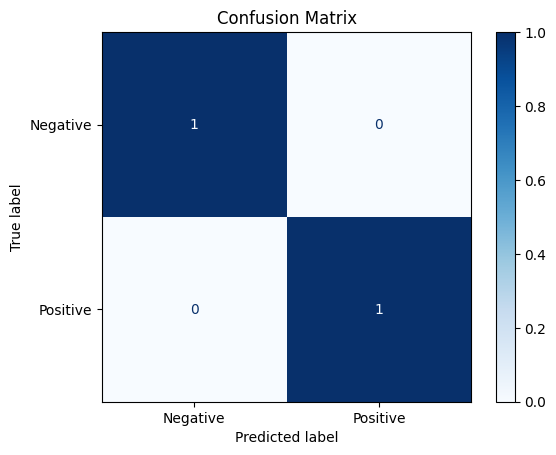

In [21]:
# Evaluation on the test set
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for texts, labels in test_dataloader:
        outputs = model(texts)
        predictions = torch.sigmoid(outputs).squeeze()
        predicted_labels = (predictions >= 0.5).long()
        all_labels.extend(labels.tolist())
        all_predictions.extend(predicted_labels.tolist())

# Plotting the Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()